In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eunpyohong","key":"43af7b0662420109167103efb8933092"}'}

In [2]:
ls -1ha kaggle.json

kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d shonenkov/melanoma-merged-external-data-512x512-jpeg

100% 4.85G/4.86G [01:15<00:00, 83.3MB/s]
100% 4.86G/4.86G [01:15<00:00, 69.1MB/s]


In [5]:
%%capture
!unzip /content/melanoma-merged-external-data-512x512-jpeg.zip

In [6]:
fold_number = 1
seed = 66
debug = False
tta = 2 if debug else 20

batch_size = {
    'tpu' : 10,
    'gpu' : 22,
    'cpu' : 4
}

arch = 'efficientnet-b5'
resolution = 456
input_res = 512

lr = 8e-6
weight_decay = 2e-5
pos_weight = 3.2
label_smoothing = 0.0

max_epochs = 7

In [7]:
%%capture
%reload_ext autoreload
%autoreload 2  # jupyter 환경에서 파이썬 코드를 실행하기전에 모듈을 reload 시켜줌
import os

# if 'TPU_NAME' in os.environ.keys():
#     try:
#         import torch_xla
#     except:
#         # XLA powers the TPU support for PyTorch
#         !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#         !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
# else:
#     # Update PyTorch to enable its native support to Mixed Precision
#     !pip install -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

!pip install -U pip albumentations==0.4.5 PyYAML pytorch-lightning==0.8.5 efficientnet_pytorch

In [8]:
import torch

num_workers = 2
gpus = 1 if torch.cuda.is_available() else None

try:
    import torch_xla.core.xla_model as xm
    tpu_cores = 8
except:
    tpu_cores = None

if isinstance(batch_size, dict):
    if tpu_cores:
        batch_size = batch_size['tpu']
        lr *= tpu_cores
        num_workers = 1
    elif gpus:
        batch_size = batch_size['gpu']
        if 'K80' in torch.cuda.get_device_name():
            batch_size = batch_size // 3
        elif 'T4' in torch.cuda.get_device_name():
            batch_size = int(batch_size * 0.66)
    else:
        batch_size = batch_size['cpu']
lr *= batch_size

dict(num_workers=num_workers,
    tpu_cores=tpu_cores,
    gpus=gpus,
    batch_size=batch_size,
    lr=lr,
    )

{'batch_size': 22,
 'gpus': 1,
 'lr': 0.000176,
 'num_workers': 2,
 'tpu_cores': None}

In [9]:
# check for torch's native mixed precision support (pt1.6+)
if gpus and not hasattr(torch.cuda, "amp"):
    try:
        from apex import amp
    except:
        !git clone https://github.com/NVIDIA/apex  nv_apex
        !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./nv_apex
        from apex import amp
    # with PyTorch Lightning all you need to do now is set precision=16

In [10]:
%%capture
!pip install --upgrade pytorch-lightning

In [11]:
import os
import time
import random
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
from skimage import io
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from glob import glob
import sklearn

import pytorch_lightning as pl
import warnings

warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed*6 + fold_number)

torch.__version__

'1.8.1+cu101'

In [12]:
from torch.utils.data import Dataset, DataLoader


class ImageDataset(Dataset):
    def __init__(self, path, image_ids, labels=None, transforms=None):
        super().__init__()
        self.path = path
        self.image_ids = image_ids
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = cv2.imread(f'{self.path}/{image_id}.jpg', cv2.IMREAD_COLOR)

        if self.transforms:
            sample = self.transforms(image=image)
            image  = sample['image']

        label = self.labels[idx] if self.labels is not None else 0.5
        return image, label

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def get_labels(self):
        return list(self.labels)

In [13]:
def get_train_transforms():
    return A.Compose([
        A.JpegCompression(p=0.5), # 이미지 용량을 줄이면서 퀄리티는 조금 손해 
        A.Rotate(limit=80, p=1.0),
        A.OneOf([  # 왜곡
            A.OpticalDistortion(),
            A.GridDistortion(),
            A.IAAPiecewiseAffine()
        ]),
        A.RandomSizedCrop(min_max_height=(int(resolution*0.7), input_res),
                         height=resolution, width=resolution, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.GaussianBlur(p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(),
            A.HueSaturationValue(),
        ]),
        A.Cutout(num_holes=8, max_h_size = resolution//8, max_w_size= resolution//8, fill_value=0, p=0.3),
        A.Normalize(),
        ToTensorV2(),
    ])

def get_valid_transforms():
    return A.Compose([
        A.CenterCrop(height=resolution, width=resolution, p=1.0),
        A.Normalize(),
        ToTensorV2(),
    ])

# test time augmentations
def get_tta_transforms():
    return A.Compose([
            A.JpegCompression(p=0.5),
            A.RandomSizedCrop(min_max_height=(int(resolution*0.9), int(resolution*1.1)),
                              height=resolution, width=resolution, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Transpose(p=0.5),  # rotate 90과 같음
            A.Normalize(),
            ToTensorV2(),
        ], p=1.0)

In [14]:
# DATA_PATH = './content/melanoma-merged-external-data-512x512-jpeg'
TRAIN_ROOT_PATH = '512x512-dataset-melanoma/512x512-dataset-melanoma'
TEST_ROOT_PATH = '512x512-test/512x512-test'

df_folds = pd.read_csv('folds.csv', index_col='image_id', usecols=['image_id','fold','target'], dtype={'fold':np.byte, 'target':np.byte})

fold,0,1,2,3,4
ratio,0.091906,0.090451,0.090457,0.090101,0.089973


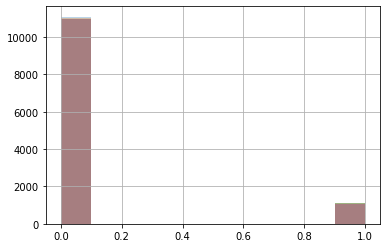

In [15]:
df_folds.groupby('fold').target.hist(alpha=0.3)
df_folds.groupby('fold').target.mean().to_frame('ratio').T

In [16]:
df_test = pd.read_csv('test.csv', index_col='image_name')
if debug:
    df_folds = df_folds.sample(batch_size*80)
    
df_folds = df_folds.sample(frac=1.0, random_state=seed*6+fold_number)

In [17]:
train_dataset = ImageDataset(
    path=TRAIN_ROOT_PATH,
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    labels = df_folds[df_folds['fold'] != fold_number].target.values,
    transforms=get_train_transforms(),
)

valid_dataset = ImageDataset(
    path=TRAIN_ROOT_PATH,
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    labels = df_folds[df_folds['fold'] == fold_number].target.values,
    transforms=get_valid_transforms(),
)

# inference
test_dataset = ImageDataset(
    path=TEST_ROOT_PATH,
    image_ids=df_test.index.values,
    transforms=get_tta_transforms(),
)

del df_folds
len(train_dataset), len(valid_dataset), len(test_dataset)

(48381, 12106, 10982)

In [18]:
from efficientnet_pytorch import EfficientNet
from pytorch_lightning.metrics.classification import AUROC
from sklearn.metrics import roc_auc_score

class Model(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.net = EfficientNet.from_pretrained(arch, advprop=True)
        self.net._fc = nn.Linear(in_features=self.net._fc.in_features, out_features=1, bias=True)

    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            max_lr=lr,
            epochs=max_epochs,
            optimizer=optimizer,
            steps_per_epoch=int(len(train_dataset) / batch_size),
            pct_start=0.1,
            div_factor=10,
            final_div_factor=100,
            base_momentum=0.90,
            max_momentum=0.95,
        )
        return [optimizer], [scheduler]

    def step(self, batch):  # forward and calculate loss
        # return batch loss
        x, y  = batch
        y_hat = self(x).flatten()
        y_smo = y.float() * (1 - label_smoothing) + 0.5 * label_smoothing
        loss  = F.binary_cross_entropy_with_logits(y_hat, y_smo.type_as(y_hat),
                                                   pos_weight=torch.tensor(pos_weight))
        return loss, y, y_hat.sigmoid()

    def training_step(self, batch, batch_nb):
        # hardware agnostic training
        loss, y, y_hat = self.step(batch)
        acc = (y_hat.round() == y).float().mean().item()
        tensorboard_logs = {'train_loss': loss, 'acc': acc}
        return {'loss': loss, 'acc': acc, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        loss, y, y_hat = self.step(batch)
        return {'val_loss': loss,
                'y': y.detach(), 'y_hat': y_hat.detach()}

    def validation_epoch_end(self, outputs):  # 한 에폭이 끝났을 때 실행
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        y = torch.cat([x['y'] for x in outputs])
        y_hat = torch.cat([x['y_hat'] for x in outputs])
        auc = AUROC()(y_hat, y) if y.float().mean() > 0 else 0.5 # skip sanity check
        acc = (y_hat.round() == y).float().mean().item()
        print(f"Epoch {self.current_epoch} acc:{acc} auc:{auc}")
        tensorboard_logs = {'val_loss': avg_loss, 'val_auc': auc, 'val_acc': acc}
        return {'avg_val_loss': avg_loss,
                'val_auc': auc, 'val_acc': acc,
                'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        x, _ = batch
        y_hat = self(x).flatten().sigmoid()
        return {'y_hat': y_hat}

    def test_epoch_end(self, outputs):
        y_hat = torch.cat([x['y_hat'] for x in outputs])
        df_test['target'] = y_hat.tolist()
        N = len(glob('submission*.csv'))
        df_test.target.to_csv(f'submission{N}.csv')
        return {'tta': N}

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers,
                          drop_last=True, shuffle=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers,
                          drop_last=False, shuffle=False, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,
                          drop_last=False, shuffle=False, pin_memory=False)

model = Model()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b5-86493f6b.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b5-86493f6b.pth



Loaded pretrained weights for efficientnet-b5


tensor([[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int8)

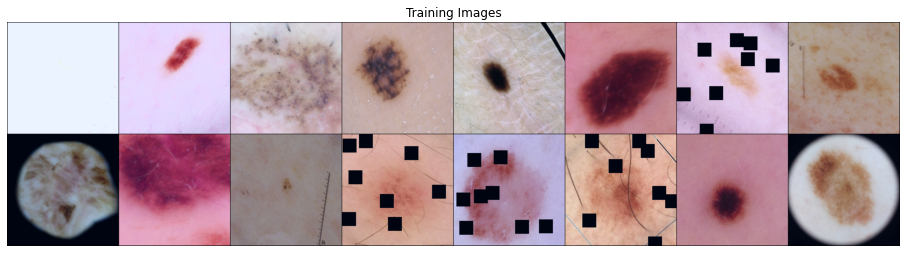

In [19]:
import torchvision.utils as vutils
batch, targets = next(iter(model.train_dataloader()))

plt.figure(figsize=(16, 8))
plt.axis('off')
plt.title('Training Images')
_ = plt.imshow(vutils.make_grid(
    batch[:16], nrow=8, padding=2, normalize=True).cpu().numpy().transpose((1,2,0)))
targets[:16].reshape([2,8]) if len(targets) >=16 else targets

In [20]:
del batch; del targets

In [31]:
checkpoint_callback = pl.callbacks.ModelCheckpoint('{epoch:02d}_{val_auc:.4f}',
                                                  save_top_k=1, monitor='val_auc', mode='max')
trainer = pl.Trainer(
    tpu_cores=tpu_cores,
    gpus=gpus,
    precision=16 if gpus else 32,
    max_epochs=max_epochs,
    num_sanity_val_steps=1 if debug else 0,  # catches any bugs in your validation without having to wait for the first validation check. 
    checkpoint_callback=checkpoint_callback
    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [22]:
import gc
torch.cuda.empty_cache(); gc.collect()
torch.cuda.empty_cache(); gc.collect()

0

In [ ]:
trainer.fit(model)

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbCg5rb%2Fbtq5XKxtk7T%2F1Pcsn8KoeATTFKAklTKIWK%2Fimg.png'> 

In [25]:
# torch.save(model.state_dict(), 'checkpoint.pth')

In [26]:
# from google.colab import files
# files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
from google.colab import drive
drive.mount('/content/gdrive') 

!cp /content/gdrive/MyDrive/data/checkpoint.pth /content/

Mounted at /content/gdrive


In [26]:
checkpoint = torch.load('checkpoint.pth')

model.load_state_dict(checkpoint)

<All keys matched successfully>